In [1]:
import os
import re
import sklearn
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from collections import Counter
from sklearn.metrics import *
from sklearn.linear_model import *
from sklearn.model_selection import *

pd.set_option('display.max_columns', None)

# Load Data

In [2]:
DATA_PATH = 'WDataFiles_Stage1/'

for filename in os.listdir(DATA_PATH):
    print(filename)

WNCAATourneySlots.csv
WTeams.csv
WSampleSubmissionStage1.csv
WNCAATourneyDetailedResults.csv
WNCAATourneyCompactResults.csv
WSeasons.csv
Cities.csv
WRegularSeasonCompactResults.csv
WTeamSpellings.csv
WRegularSeasonDetailedResults.csv
WNCAATourneySeeds.csv
WTeamConferences.csv
Conferences.csv
WGameCities.csv


## Seeds

Data Section 1 file: WNCAATourneySeeds.csv

This file identifies the seeds for all teams in each NCAA® tournament, for all seasons of historical data. Thus, there are exactly 64 rows for each year, since there are no play-in teams in the women's tournament. We will not know the seeds of the respective tournament teams, or even exactly which 64 teams it will be, until Selection Monday on March 14, 2022 (DayNum=133).

In [3]:
df_seeds = pd.read_csv(DATA_PATH + "WNCAATourneySeeds.csv")
df_seeds

,Season,Seed,TeamID
0,1998,W01,3330
1,1998,W02,3163
2,1998,W03,3112
3,1998,W04,3301
4,1998,W05,3272
...,...,...,...
1467,2021,Z12,3141
1468,2021,Z13,3226
1469,2021,Z14,3292
1470,2021,Z15,3238


In [4]:
df_seeds.Seed.unique()

array(['W01', 'W02', 'W03', 'W04', 'W05', 'W06', 'W07', 'W08', 'W09',
       'W10', 'W11', 'W12', 'W13', 'W14', 'W15', 'W16', 'X01', 'X02',
       'X03', 'X04', 'X05', 'X06', 'X07', 'X08', 'X09', 'X10', 'X11',
       'X12', 'X13', 'X14', 'X15', 'X16', 'Y01', 'Y02', 'Y03', 'Y04',
       'Y05', 'Y06', 'Y07', 'Y08', 'Y09', 'Y10', 'Y11', 'Y12', 'Y13',
       'Y14', 'Y15', 'Y16', 'Z01', 'Z02', 'Z03', 'Z04', 'Z05', 'Z06',
       'Z07', 'Z08', 'Z09', 'Z10', 'Z11', 'Z12', 'Z13', 'Z14', 'Z15',
       'Z16'], dtype=object)

## Slots

In [5]:
df_slot = pd.read_csv(DATA_PATH + "WNCAATourneySlots.csv")
df_slot

,Slot,StrongSeed,WeakSeed
0,R1W1,W01,W16
1,R1W2,W02,W15
2,R1W3,W03,W14
3,R1W4,W04,W13
4,R1W5,W05,W12
...,...,...,...
58,R4Y1,R3Y1,R3Y2
59,R4Z1,R3Z1,R3Z2
60,R5WX,R4W1,R4X1
61,R5YZ,R4Y1,R4Z1


## Season results

Data Section 1 file: WRegularSeasonCompactResults.csv

This file identifies the game-by-game results for many seasons of historical data, starting with the 1998 season. For each season, the file includes all games played from DayNum 0 through 132. It is important to realize that the "Regular Season" games are simply defined to be all games played on DayNum=132 or earlier (DayNum=133 is Selection Monday). Thus a game played before Selection Monday will show up here whether it was a pre-season tournament, a non-conference game, a regular conference game, a conference tournament game, or whatever.

In [6]:
df_season = pd.read_csv(DATA_PATH + "WRegularSeasonCompactResults.csv")
df_season.drop(['NumOT', 'WLoc'], axis=1, inplace=True)
df_season

,Season,DayNum,WTeamID,WScore,LTeamID,LScore
0,1998,18,3104,91,3202,41
1,1998,18,3163,87,3221,76
2,1998,18,3222,66,3261,59
3,1998,18,3307,69,3365,62
4,1998,18,3349,115,3411,35
...,...,...,...,...,...,...
119272,2022,98,3359,73,3190,61
119273,2022,98,3360,81,3334,77
119274,2022,98,3379,60,3427,57
119275,2022,98,3388,88,3365,81


In [8]:
df_season['ScoreGap'] = df_season['WScore'] - df_season['LScore']
df_season.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,ScoreGap
0,1998,18,3104,91,3202,41,50
1,1998,18,3163,87,3221,76,11
2,1998,18,3222,66,3261,59,7
3,1998,18,3307,69,3365,62,7
4,1998,18,3349,115,3411,35,80


In [9]:
win=df_season.groupby(['Season', 'WTeamID']).agg(NumWins=('DayNum','count'),
                                             AvgWinsGap=('ScoreGap','mean'),
                                             W_TotalPoints=('WScore', 'sum'),
                                             W_MaxPoints=('WScore', 'max'),
                                             W_MinPoints=('WScore', 'min')).reset_index().rename(columns={"WTeamID": "TeamID"})
                                             
loss=df_season.groupby(['Season', 'LTeamID']).agg(NumLosses=('DayNum','count'),
                                             AvgLossesGap=('ScoreGap','mean'),
                                             L_TotalPoints=('LScore', 'sum'),
                                             L_MaxPoints=('LScore', 'max'),
                                             L_MinPoints=('LScore', 'min')).reset_index().rename(columns={"LTeamID": "TeamID"})                                               

In [10]:
# create team list containing all historical data
df_features = win.merge(loss, on=['Season','TeamID'], how='outer').drop_duplicates().sort_values(['Season', 'TeamID']).reset_index(drop=True)
df_features.fillna(0, inplace=True)  

In [11]:
df_features.head()

,Season,TeamID,NumWins,AvgWinsGap,W_TotalPoints,W_MaxPoints,W_MinPoints,NumLosses,AvgLossesGap,L_TotalPoints,L_MaxPoints,L_MinPoints
0,1998,3102,4.0,15.500000,263.0,81.0,59.0,20.0,27.850000,1112.0,74.0,39.0
1,1998,3103,11.0,15.000000,842.0,89.0,64.0,18.0,18.611111,1166.0,91.0,47.0
2,1998,3104,21.0,21.619048,1657.0,104.0,62.0,9.0,5.666667,640.0,90.0,58.0
3,1998,3106,6.0,8.333333,421.0,80.0,58.0,15.0,14.466667,865.0,73.0,36.0
4,1998,3108,12.0,17.750000,898.0,84.0,66.0,11.0,16.636364,662.0,75.0,47.0


In [12]:
df_features['WinRatio'] = df_features['NumWins'] / (df_features['NumWins'] + df_features['NumLosses'])

df_features['AvgScoreGap'] = (
    (df_features['NumWins']*df_features['AvgWinsGap']-df_features['NumLosses']*df_features['AvgLossesGap'])
    /(df_features['NumWins'] + df_features['NumLosses']))

df_features['PointsRatio'] = df_features['W_TotalPoints'] / (df_features['W_TotalPoints'] + df_features['L_TotalPoints'])

In [13]:
cols = ['Season','TeamID','WinRatio', 'AvgScoreGap','PointsRatio']
df_features_s = df_features[cols]
df_features_s

,Season,TeamID,WinRatio,AvgScoreGap,PointsRatio
0,1998,3102,0.166667,-20.625000,0.191273
1,1998,3103,0.379310,-5.862069,0.419323
2,1998,3104,0.700000,13.433333,0.721376
3,1998,3106,0.285714,-7.952381,0.327372
4,1998,3108,0.521739,1.304348,0.575641
...,...,...,...,...,...
8400,2022,3468,0.052632,-18.526316,0.062847
8401,2022,3469,0.176471,-14.941176,0.209189
8402,2022,3470,0.444444,-5.944444,0.491210
8403,2022,3471,0.444444,-2.333333,0.513333


## Tourney results

Data Section 1 file: WNCAATourneyCompactResults.csv

This file identifies the game-by-game NCAA® tournament results for all seasons of historical data. The data is formatted exactly like the WRegularSeasonCompactResults data. Each season you will see 63 games listed, since there are no women's play-in games.

Although the scheduling of the men's tournament rounds has been consistent for many years, there has been more variety in the scheduling of the women's rounds. There have been four different schedules over the course of the past 20+ years for the women's tournament, as follows:

In [14]:
df_tourney = pd.read_csv(DATA_PATH + "WNCAATourneyCompactResults.csv")
df_tourney.drop(['NumOT', 'WLoc'], axis=1, inplace=True)
df_tourney

,Season,DayNum,WTeamID,WScore,LTeamID,LScore
0,1998,137,3104,94,3422,46
1,1998,137,3112,75,3365,63
2,1998,137,3163,93,3193,52
3,1998,137,3198,59,3266,45
4,1998,137,3203,74,3208,72
...,...,...,...,...,...,...
1444,2021,148,3376,62,3400,34
1445,2021,148,3390,78,3257,63
1446,2021,151,3112,69,3163,59
1447,2021,151,3390,66,3376,65


In [15]:
df_tourney = df_tourney.rename(columns = {'WTeamID' : 'W_TeamID', 'LTeamID' : 'L_TeamID', 'WScore' : 'W_Score', 'LScore' : 'L_Score'}) 

## FiveThirtyEight Ratings

In [16]:
df_538 = pd.read_csv("538ratingsWomen.csv")
df_538.drop('TeamName', axis=1, inplace=True)

df_538.head()

,Season,TeamID,538rating
0,2016,3163,113.09
1,2016,3124,101.59
2,2016,3323,101.07
3,2016,3376,101.07
4,2016,3268,99.01


# Feature Engineering

## Train data

In [17]:
# train data
df = df_tourney.copy()
df = df[df['Season'] >= 2016].reset_index(drop=True)

df.head()

,Season,DayNum,W_TeamID,W_Score,L_TeamID,L_Score
0,2016,137,3107,61,3196,59
1,2016,137,3113,74,3308,52
2,2016,137,3120,68,3385,57
3,2016,137,3124,89,3225,59
4,2016,137,3177,97,3241,67


In [18]:
# merge with seeds
df = pd.merge(df, df_seeds, how='left', 
    left_on=['Season', 'W_TeamID'], right_on=['Season', 'TeamID']
             ).drop('TeamID', axis=1).rename(columns={'Seed': 'W_Seed'})

df = pd.merge(df, df_seeds, how='left', 
    left_on=['Season', 'L_TeamID'], right_on=['Season', 'TeamID']
             ).drop('TeamID', axis=1).rename(columns={'Seed': 'L_Seed'})

In [19]:
# only get the number, remove the region letter
def treat_seed(seed):
    return int(re.sub("[^0-9]", "", seed))

df['W_Seed'] = df['W_Seed'].apply(treat_seed)
df['L_Seed'] = df['L_Seed'].apply(treat_seed)

In [487]:
df_features_s

,Season,TeamID,WinRatio,AvgScoreGap,PointsRatio
0,1998,3102,0.166667,-20.625000,0.191273
1,1998,3103,0.379310,-5.862069,0.419323
2,1998,3104,0.700000,13.433333,0.721376
3,1998,3106,0.285714,-7.952381,0.327372
4,1998,3108,0.521739,1.304348,0.575641
...,...,...,...,...,...
8400,2022,3468,0.052632,-18.526316,0.062847
8401,2022,3469,0.176471,-14.941176,0.209189
8402,2022,3470,0.444444,-5.944444,0.491210
8403,2022,3471,0.444444,-2.333333,0.513333


In [21]:
# merge with features
df = pd.merge(df, df_features_s, how='left',
    left_on=['Season', 'W_TeamID'], right_on=['Season', 'TeamID']
).rename(columns={
    'NumWins': 'W_NumWins',
    'NumLosses': 'W_NumLosses',
    'GapWins': 'W_GapWins',
    'GapLosses': 'W_GapLosses',
    'WinRatio': 'W_WinRatio',
    'AvgScoreGap': 'W_AvgScoreGap',
    'PointsRatio': 'W_PointsRatio',
}).drop(columns='TeamID', axis=1)

df = pd.merge(df, df_features_s, how='left',
    left_on=['Season', 'L_TeamID'], right_on=['Season', 'TeamID']
).rename(columns={
    'NumWins': 'L_NumWins',
    'NumLosses': 'L_NumLosses',
    'GapWins': 'L_GapWins',
    'GapLosses': 'L_GapLosses',
    'WinRatio': 'L_WinRatio',
    'AvgScoreGap': 'L_AvgScoreGap',
    'PointsRatio': 'L_PointsRatio',
}).drop(columns='TeamID', axis=1)

In [22]:
df.head()

,Season,DayNum,W_TeamID,W_Score,L_TeamID,L_Score,W_Seed,L_Seed,W_WinRatio,W_AvgScoreGap,W_PointsRatio,L_WinRatio,L_AvgScoreGap,L_PointsRatio
0,2016,137,3107,61,3196,59,12,5,0.870968,18.677419,0.892371,0.733333,8.700000,0.766239
1,2016,137,3113,74,3308,52,2,15,0.806452,9.258065,0.828093,0.857143,8.964286,0.881409
2,2016,137,3120,68,3385,57,9,8,0.612903,3.032258,0.689315,0.718750,6.812500,0.748601
3,2016,137,3124,89,3225,59,1,16,0.970588,24.617647,0.982974,0.709677,10.612903,0.758355
4,2016,137,3177,97,3241,67,6,11,0.757576,16.272727,0.780689,0.843750,15.406250,0.869546


In [23]:
# merge with 538
df = pd.merge(df, df_538, how='left',
    left_on=['Season', 'W_TeamID'], right_on=['Season', 'TeamID']
             ).drop('TeamID', axis=1).rename(columns={'538rating': 'W_538rating'})

df = pd.merge(df, df_538, how='left', 
    left_on=['Season', 'L_TeamID'], right_on=['Season', 'TeamID']
             ).drop('TeamID', axis=1).rename(columns={'538rating': 'L_538rating'})

In [25]:
def replace_win_loser(df):
    team_a = df.copy()
    team_b = df.copy()
    
    team_a_dict, team_b_dict = {}, {}
    
    for col in team_a.columns:
        if col.find('W_') == 0:
            new_col_name = str(col).replace('W_', 'A_')
            team_a_dict[col] = new_col_name
        if col.find('L_') == 0:
            new_col_name = col.replace('L_', 'B_')    
            team_a_dict[col] = new_col_name
            
    for col in team_b.columns:
        if col.find('W_') == 0:
            new_col_name = str(col).replace('W_', 'B_')
            team_b_dict[col] = new_col_name
        if col.find('L_') == 0:
            new_col_name = col.replace('L_', 'A_')
            team_b_dict[col] = new_col_name

    team_a = team_a.rename(columns = team_a_dict)
    team_b = team_b.rename(columns = team_b_dict)
    
    merged_df = pd.concat([team_a, team_b], axis = 0, sort = False)
    return merged_df

In [26]:
df = replace_win_loser(df).reset_index(drop=True)
df.head()

,Season,DayNum,A_TeamID,A_Score,B_TeamID,B_Score,A_Seed,B_Seed,A_WinRatio,A_AvgScoreGap,A_PointsRatio,B_WinRatio,B_AvgScoreGap,B_PointsRatio,A_538rating,B_538rating
0,2016,137,3107,61,3196,59,12,5,0.870968,18.677419,0.892371,0.733333,8.700000,0.766239,80.90,83.36
1,2016,137,3113,74,3308,52,2,15,0.806452,9.258065,0.828093,0.857143,8.964286,0.881409,91.32,71.42
2,2016,137,3120,68,3385,57,9,8,0.612903,3.032258,0.689315,0.718750,6.812500,0.748601,80.17,82.19
3,2016,137,3124,89,3225,59,1,16,0.970588,24.617647,0.982974,0.709677,10.612903,0.758355,101.59,72.69
4,2016,137,3177,97,3241,67,6,11,0.757576,16.272727,0.780689,0.843750,15.406250,0.869546,90.08,83.04


In [27]:
cols_to_diff = ['Seed', 'WinRatio', 'AvgScoreGap', 'PointsRatio', '538rating']

for col in cols_to_diff:
    df[col + 'Diff'] = df['A_'+col] - df['B_'+col]

In [28]:
# Create target variable

df['ScoreDiff'] = df['A_Score'] - df['B_Score']
df['A_Win'] = (df['ScoreDiff'] > 0).astype(int)
df = df.drop(columns=['A_Score', 'B_Score'])

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 630 entries, 0 to 629
Data columns (total 21 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Season           630 non-null    int64  
 1   DayNum           630 non-null    int64  
 2   A_TeamID         630 non-null    int64  
 3   B_TeamID         630 non-null    int64  
 4   A_Seed           630 non-null    int64  
 5   B_Seed           630 non-null    int64  
 6   A_WinRatio       630 non-null    float64
 7   A_AvgScoreGap    630 non-null    float64
 8   A_PointsRatio    630 non-null    float64
 9   B_WinRatio       630 non-null    float64
 10  B_AvgScoreGap    630 non-null    float64
 11  B_PointsRatio    630 non-null    float64
 12  A_538rating      630 non-null    float64
 13  B_538rating      630 non-null    float64
 14  SeedDiff         630 non-null    int64  
 15  WinRatioDiff     630 non-null    float64
 16  AvgScoreGapDiff  630 non-null    float64
 17  PointsRatioDiff 

In [481]:
df.head()

,Season,DayNum,A_TeamID,B_TeamID,A_Seed,B_Seed,A_WinRatio,A_AvgScoreGap,A_PointsRatio,B_WinRatio,...,B_PointsRatio,A_538rating,B_538rating,SeedDiff,WinRatioDiff,AvgScoreGapDiff,PointsRatioDiff,538ratingDiff,ScoreDiff,A_Win
0,2016,137,3107,3196,12,5,0.870968,18.677419,0.892371,0.733333,...,0.766239,80.90,83.36,7,0.137634,9.977419,0.126131,-2.46,2,1
1,2016,137,3113,3308,2,15,0.806452,9.258065,0.828093,0.857143,...,0.881409,91.32,71.42,-13,-0.050691,0.293779,-0.053315,19.90,22,1
2,2016,137,3120,3385,9,8,0.612903,3.032258,0.689315,0.718750,...,0.748601,80.17,82.19,1,-0.105847,-3.780242,-0.059285,-2.02,11,1
3,2016,137,3124,3225,1,16,0.970588,24.617647,0.982974,0.709677,...,0.758355,101.59,72.69,-15,0.260911,14.004744,0.224619,28.90,30,1
4,2016,137,3177,3241,6,11,0.757576,16.272727,0.780689,0.843750,...,0.869546,90.08,83.04,-5,-0.086174,0.866477,-0.088857,7.04,30,1


## Test data (hold out data)

In [30]:
df_test = pd.read_csv(DATA_PATH + "WSampleSubmissionStage1.csv")

In [31]:
df_test['Season'] = df_test['ID'].apply(lambda x: int(x.split('_')[0]))
df_test['A_TeamID'] = df_test['ID'].apply(lambda x: int(x.split('_')[1]))
df_test['B_TeamID'] = df_test['ID'].apply(lambda x: int(x.split('_')[2]))

In [32]:
df_test = pd.merge(
    df_test,
    df_seeds,
    how='left',
    left_on=['Season', 'A_TeamID'],
    right_on=['Season', 'TeamID']
).drop('TeamID', axis=1).rename(columns={'Seed': 'A_Seed'})

df_test = pd.merge(
    df_test, 
    df_seeds, 
    how='left', 
    left_on=['Season', 'B_TeamID'], 
    right_on=['Season', 'TeamID']
).drop('TeamID', axis=1).rename(columns={'Seed': 'B_Seed'})


In [33]:
df_test['A_Seed'] = df_test['A_Seed'].apply(treat_seed)
df_test['B_Seed'] = df_test['B_Seed'].apply(treat_seed)

In [34]:
df_test = pd.merge(df_test, df_features_s, how='left',
    left_on=['Season', 'A_TeamID'], right_on=['Season', 'TeamID']
).rename(columns={
    'NumWins': 'A_NumWins',
    'NumLosses': 'A_NumLosses',
    'GapWins': 'A_GapWins',
    'GapLosses': 'A_GapLosses',
    'WinRatio': 'A_WinRatio',
    'AvgScoreGap': 'A_AvgScoreGap',
    'PointsRatio': 'A_PointsRatio',
}).drop(columns='TeamID', axis=1)

df_test = pd.merge(df_test, df_features_s, how='left',
    left_on=['Season', 'B_TeamID'], right_on=['Season', 'TeamID']
).rename(columns={
    'NumWins': 'B_NumWins',
    'NumLosses': 'B_NumLosses',
    'GapWins': 'B_GapWins',
    'GapLosses': 'B_GapLosses',
    'WinRatio': 'B_WinRatio',
    'AvgScoreGap': 'B_AvgScoreGap',
    'PointsRatio': 'B_PointsRatio',
}).drop(columns='TeamID', axis=1)

In [35]:
# merge with 538
df_test = pd.merge(df_test, df_538, how='left',
    left_on=['Season', 'A_TeamID'], right_on=['Season', 'TeamID']
             ).drop('TeamID', axis=1).rename(columns={'538rating': 'A_538rating'})

df_test = pd.merge(df_test, df_538, how='left', 
    left_on=['Season', 'B_TeamID'], right_on=['Season', 'TeamID']
             ).drop('TeamID', axis=1).rename(columns={'538rating': 'B_538rating'})

In [36]:
cols_to_diff = ['Seed', 'WinRatio', 'AvgScoreGap', 'PointsRatio', '538rating']

for col in cols_to_diff:
    df_test[col + 'Diff'] = df_test['A_'+col] - df_test['B_'+col]

# Build model

In [37]:
from sklearn import tree
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import log_loss
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

In [38]:
target_feature = 'A_Win'
cols = ['ScoreDiff', 'Season', 'DayNum', 'A_Win']
features = [col for col in df.columns if col not in cols]
features

['A_TeamID',
 'B_TeamID',
 'A_Seed',
 'B_Seed',
 'A_WinRatio',
 'A_AvgScoreGap',
 'A_PointsRatio',
 'B_WinRatio',
 'B_AvgScoreGap',
 'B_PointsRatio',
 'A_538rating',
 'B_538rating',
 'SeedDiff',
 'WinRatioDiff',
 'AvgScoreGapDiff',
 'PointsRatioDiff',
 '538ratingDiff']

In [39]:
features = ['A_TeamID',
 'B_TeamID',
 'A_Seed',
 'B_Seed',
 'A_WinRatio',
 'A_AvgScoreGap',
 #'A_PointsRatio',
 'B_WinRatio',
 'B_AvgScoreGap',
 #'B_PointsRatio',
 'A_538rating',
 'B_538rating',
 'SeedDiff',
 'WinRatioDiff',
 'AvgScoreGapDiff',
 #'PointsRatioDiff',
 '538ratingDiff']

In [40]:
def xgb_model(train_df, test_df, features, target_feature):
    print(features)
    
    i=1
    cvs_train = []
    cvs_val = []
    pred_test = np.zeros(len(test_df))
    preds_test = []
    pred_val_df = pd.DataFrame(np.zeros(len(train_df)),columns=['pred_val'])
    importancias=pd.DataFrame()
    importancias['variable']=features
    
    seasons = df['Season'].unique()
    for s in seasons[1:]:
        print(f'\nValidating on season {s}')
        X_train = train_df[train_df['Season'] < s][features].reset_index(drop = True).copy()
        X_val = train_df[train_df['Season'] == s][features].reset_index(drop = True).copy()
        val_index = train_df[train_df['Season'] == s].index
    
        y_train = train_df[train_df['Season'] < s][target_feature].reset_index(drop = True).copy()
        y_val = train_df[train_df['Season'] == s][target_feature].reset_index(drop = True).copy()
    
        X_test = test_df[features].copy()
        
        # scale
        scaler = MinMaxScaler()
        X_train = scaler.fit_transform(X_train)
        X_val = scaler.transform(X_val)
        X_test = scaler.transform(X_test)
        
        # model fit
        params = {'learning_rate':0.5,
                  'max_depth':4,
                  'grow_policy':'lossguide',
                  #'gamma':0.5
        }

        model = XGBClassifier(**params, n_estimators=1024, random_state = 85, use_label_encoder=False, eval_metric='logloss')
        model.fit(X_train, y_train, eval_set = [(X_val, y_val)], verbose = 0, early_stopping_rounds = 128)
        importancias['gain_'+ str(i)] = model.feature_importances_
        i=i+1
        
        
        # teain
        pred_train = model.predict_proba(X_train)[:, 1]
        loss_train = log_loss(y_train, pred_train)
        
        # val
        pred_val = model.predict_proba(X_val)[:, 1]
        pred_val_df.iloc[val_index,0] = pd.Series(pred_val).values
        loss_val = log_loss(y_val, pred_val)
        
        cvs_train.append(loss_train)
        cvs_val.append(loss_val)
        print(f'\t -> Scored {loss_val:.4f}')
        
        # test
        pred_test = model.predict_proba(X_test)[:, 1]
        preds_test.append(pred_test)

      
    importancias["gain_avg"]=importancias[["gain_1","gain_2","gain_3","gain_4"]].mean(axis=1)
    importancias=importancias.sort_values("gain_avg",ascending=False).reset_index(drop=True)

    predictions = np.mean(preds_test, 0)    
    result = {}
    result['cvs_train'] = cvs_train
    result['cvs_val'] = cvs_val
    result['importancias']=importancias
    result['pred_val'] = pred_val_df
    result['predictions'] = predictions

    
    return result

In [41]:
result1= xgb_model(df, df_test, features, target_feature)

['A_TeamID', 'B_TeamID', 'A_Seed', 'B_Seed', 'A_WinRatio', 'A_AvgScoreGap', 'B_WinRatio', 'B_AvgScoreGap', 'A_538rating', 'B_538rating', 'SeedDiff', 'WinRatioDiff', 'AvgScoreGapDiff', '538ratingDiff']

Validating on season 2017
	 -> Scored 0.4754

Validating on season 2018
	 -> Scored 0.5332

Validating on season 2019
	 -> Scored 0.4251

Validating on season 2021
	 -> Scored 0.4095


training loss 0.2555996140747863
validation loss 0.4608042297777646


<BarContainer object of 14 artists>

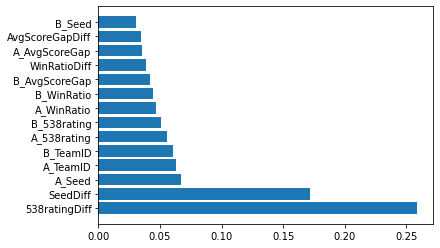

In [42]:
#print(result1['cvs_train'])
print('training loss', sum(result1['cvs_train']) / len(result1['cvs_train']))
#print( result1['cvs_val'])
print('validation loss', sum(result1['cvs_val']) / len(result1['cvs_val']))
data = result1['importancias'].sort_values('gain_avg', ascending=False)
plt.barh('variable','gain_avg',data=data)

In [43]:
# feature selection
features_selected=data['variable'].tolist()[0:2]
features_selected

['538ratingDiff', 'SeedDiff']

In [44]:
result2= xgb_model(df, df_test, features_selected, target_feature)
#print(result2['cvs_train'])
print('training loss', sum(result2['cvs_train']) / len(result2['cvs_train']))
#print( result1['cvs_val'])
print('validation loss', sum(result2['cvs_val']) / len(result2['cvs_val']))

['538ratingDiff', 'SeedDiff']

Validating on season 2017
	 -> Scored 0.4533

Validating on season 2018
	 -> Scored 0.5140

Validating on season 2019
	 -> Scored 0.4046

Validating on season 2021
	 -> Scored 0.4106
training loss 0.3065100818076023
validation loss 0.44563807764401037


# Submission

In [582]:
sub = df_test[['ID', 'Pred']].copy()
sub['Pred'] = result2['predictions']
sub.to_csv('submission.csv', index = False)

# Evaluate result

In [45]:
df_result = pd.concat([df, result1['pred_val']], axis=1)

In [46]:
df_result = df_result[df_result['pred_val'] > 0]

df_result['Win_pred'] = df_result['pred_val'].apply(lambda x: 1 if x >0.5 else 0)
df_result

,Season,DayNum,A_TeamID,B_TeamID,A_Seed,B_Seed,A_WinRatio,A_AvgScoreGap,A_PointsRatio,B_WinRatio,B_AvgScoreGap,B_PointsRatio,A_538rating,B_538rating,SeedDiff,WinRatioDiff,AvgScoreGapDiff,PointsRatioDiff,538ratingDiff,ScoreDiff,A_Win,pred_val,Win_pred
63,2017,137,3113,3277,8,9,0.612903,6.161290,0.663276,0.656250,7.031250,0.686017,87.68,84.28,-1,-0.043347,-0.869960,-0.022741,3.40,12,1,0.760511,1
64,2017,137,3166,3405,7,10,0.766667,8.066667,0.793835,0.750000,8.281250,0.782222,79.96,76.26,-3,0.016667,-0.214583,0.011613,3.70,27,1,0.190477,0
65,2017,137,3177,3320,7,10,0.787879,13.727273,0.807505,0.741935,9.387097,0.768971,87.94,77.10,-3,0.045943,4.340176,0.038534,10.84,21,1,0.946857,1
66,2017,137,3199,3442,3,14,0.806452,21.806452,0.841700,0.800000,9.800000,0.838242,94.36,71.83,-11,0.006452,12.006452,0.003459,22.53,21,1,0.902640,1
67,2017,137,3246,3125,4,13,0.677419,8.193548,0.686988,0.838710,12.096774,0.873491,89.12,73.32,-9,-0.161290,-3.903226,-0.186503,15.80,3,1,0.969180,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
625,2021,148,3400,3376,6,1,0.666667,7.074074,0.723754,0.846154,17.500000,0.885328,86.82,101.83,5,-0.179487,-10.425926,-0.161574,-15.01,-28,0,0.055329,0
626,2021,148,3257,3390,2,1,0.884615,16.884615,0.914425,0.925926,25.703704,0.934844,96.01,106.54,1,-0.041311,-8.819088,-0.020419,-10.53,-15,0,0.342103,0
627,2021,151,3163,3112,1,3,0.960000,31.520000,0.957582,0.761905,10.523810,0.796853,104.27,93.87,-2,0.198095,20.996190,0.160729,10.40,-10,0,0.680826,1
628,2021,151,3376,3390,1,1,0.846154,17.500000,0.885328,0.925926,25.703704,0.934844,101.83,106.54,0,-0.079772,-8.203704,-0.049516,-4.71,-1,0,0.454524,0


In [47]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

print(accuracy_score(df_result['A_Win'], df_result['Win_pred']))
print(confusion_matrix(df_result['A_Win'], df_result['Win_pred']))
print(classification_report(df_result['A_Win'], df_result['Win_pred']))

0.7876984126984127
[[198  54]
 [ 53 199]]
              precision    recall  f1-score   support

           0       0.79      0.79      0.79       252
           1       0.79      0.79      0.79       252

    accuracy                           0.79       504
   macro avg       0.79      0.79      0.79       504
weighted avg       0.79      0.79      0.79       504



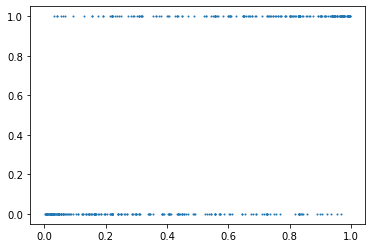

In [48]:
plt.scatter('pred_val','A_Win', s=1, data=df_result)

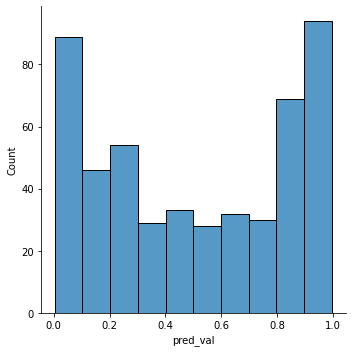

In [49]:
sns.displot(df_result['pred_val'])

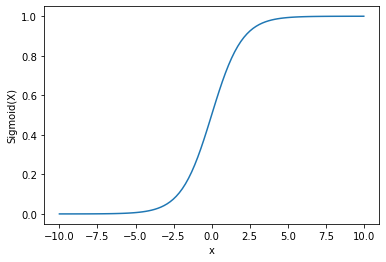

In [50]:
import math
  
x = np.linspace(-10, 10, 100)
z = 1/(1 + np.exp(-x))
  
plt.plot(x, z)
plt.xlabel("x")
plt.ylabel("Sigmoid(X)")
  
plt.show()